In [82]:
!pip install opencv-contrib-python

     |████████████████████████████████| 57.4 MB 12.2 MB/s eta 0:00:01


# %matplotlib inline

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

In [92]:
def iterate_over_mask(img, mask):
    segments = np.unique(mask)
    
    for segment in segments:
        print(segment)
        yield segment, get_subimage(img, mask == segment)
        
def get_luminance_weighted_mask(img_hls, mask_function=get_rule_of_thirds_mask, mask_kwargs={}):
    mask = mask_function(img_hls, **mask_kwargs)

    replacements = {}
    for segment_idx, mask_subimg in iterate_over_mask(img_hls, mask):
        replacements[segment_idx] = np.median(mask_subimg[:,:,1])
        
    flat_mask = mask.flatten()
    return pd.Series(flat_mask).map(replacements).values.reshape(*mask.shape)

def get_subimage(img, mask):
    x = np.max(mask, 1).sum()
    y = np.max(mask, 0).sum()
    
    return np.moveaxis(np.stack(
        [np.extract(mask, img[:,:,0]).reshape(x, y)
        ,np.extract(mask, img[:,:,1]).reshape(x, y)
        ,np.extract(mask, img[:,:,2]).reshape(x, y)]
    ), 0, -1)

def sliding_grid():
    original_x_size, original_y_size = img.shape[:2]
    
    mask_matrix = np.zeros(img.shape[:2])
    
    cnt = 0
    x_steps = list(range(0, original_x_size, int(original_x_size/n))) + [original_x_size]
    y_steps = list(range(0, original_y_size, int(original_y_size/n))) + [original_y_size]
    for from_x, to_x in list(zip(x_steps, x_steps[1:]))[:n]:
        for from_y, to_y in list(zip(y_steps, y_steps[1:]))[:n]:            
            mask_matrix[from_x:to_x, from_y:to_y] = cnt
            cnt += 1
    
    return mask_matrix

def get_palette(hls_palette):
    paleta = list(map(lambda cl: colorsys.hls_to_rgb(cl[0], cl[1], cl[2]), hls_palette))
    
    return paleta

def quantize_img(palette_index_matrix, palette=np_itten_color_wheel):
    shape = palette_index_matrix.shape
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

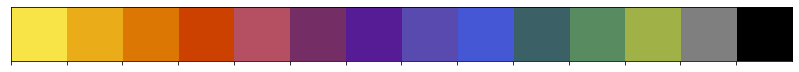

In [107]:
sns.palplot(get_palette(np_wb_itten_color_wheel))

In [40]:
itten_color_wheel

[[0.14722222222222223, 0.63, 0.94],
 [0.11666666666666667, 0.51, 0.84],
 [0.08888888888888889, 0.44, 0.97],
 [0.05277777777777778, 0.4, 1.0],
 [0.9694444444444444, 0.51, 0.4],
 [0.8694444444444445, 0.32, 0.44],
 [0.7444444444444445, 0.35, 0.68],
 [0.6888888888888889, 0.49, 0.4],
 [0.6472222222222223, 0.56, 0.64],
 [0.5222222222222223, 0.32, 0.27],
 [0.3611111111111111, 0.45, 0.22],
 [0.19444444444444445, 0.49, 0.43]]

In [46]:
0.11*360

39.6

# Carga archivos

In [3]:
cam = glob.glob('../../Osintgram/output/*.jpg')

In [4]:
mbkmeans = MiniBatchKMeans(n_clusters=128)

In [4]:
img = cv2.imread(cam[0])

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)


In [102]:
def get_color_wheel_quantized_img(img_hls, color_wheel=np_itten_color_wheel):
    distance = cdist(get_full_normalized_hls(img_hls).reshape(-1,3), color_wheel).reshape(img_hls.shape[1], img_hls.shape[0], color_wheel.shape[0])

    itten_img = np.argmin(distance, axis=2).T
    
    return itten_img

In [90]:
def get_kmeans_quantized_img(img_hls, clustering_method = KMeans()):
    km = KMeans()
    km = km.fit(get_full_normalized_hls(img_hls).reshape(-1,3))
    
    palette = km.cluster_centers_
    prediction = km.predict(get_full_normalized_hls(img_hls).reshape(-1,3)).reshape(img_hls.shape[1], img_hls.shape[0]).T
    
    return prediction, palette, km

In [76]:
get_color_wheel_quantized_img(img_hls, color_wheel=np_wb_itten_color_wheel)

array([[13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [13,  4,  4, ...,  4,  4,  4]])

In [91]:
kmeans_palette_matrix, palette, km = get_kmeans_quantized_img(img_hls)

In [ ]:
KMeans().fit_transform

In [101]:
kmeans_palette_matrix

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [6, 6, 6, ..., 1, 6, 6],
       [6, 6, 6, ..., 1, 6, 6],
       [4, 6, 1, ..., 1, 6, 6]], dtype=int32)

In [104]:
get_color_wheel_quantized_img(img_hls, palette)

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [6, 6, 6, ..., 1, 6, 6],
       [6, 6, 6, ..., 1, 6, 6],
       [4, 6, 1, ..., 1, 6, 6]])

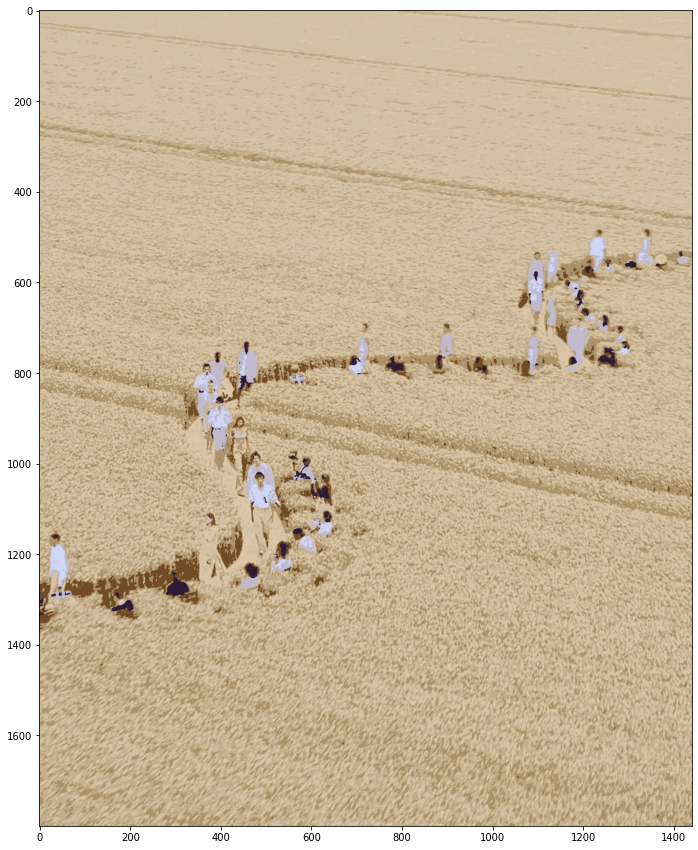

In [108]:
plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(np.uint8(quantize_img_color_wheel(img_hls, palette) * (180, 255, 255)), cv2.COLOR_HLS2RGB))

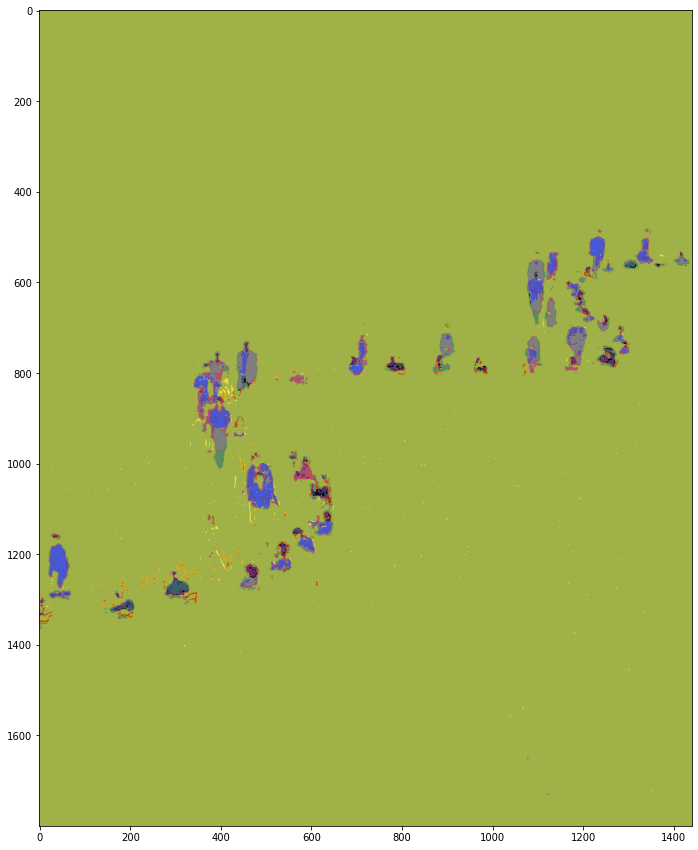

In [105]:
plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(np.uint8(quantize_img_color_wheel(img_hls, np_wb_itten_color_wheel) * (180, 255, 255)), cv2.COLOR_HLS2RGB))